<h1><center><font size="6">Santander Customer Transaction Prediction</font></center></h1>




![](https://repository-images.githubusercontent.com/194005993/5b4f4380-98b3-11e9-8232-7c56c92d78d8)


# <a id='1'>Introduction</a>  

The *Santander Customer Transaction Prediction* challenge, we have to identify which customers will make a specific transaction in the future, irrespective of the amount of money transacted. For this competition, Santander provided data that has same structure as real data. In this project I´m Using the CRISP-DM methodology for projects about data mining. 
<img src="https://www.datocms-assets.com/6503/1546015659-crispen.png" width="500"></img>

As a first statment, we have the **business understanding**, 
* What is the objective of the main project?
The objective is to identify which customers will make a specific transaction in the future in the Santander bank.

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.random import randint
import plotly.express as px
from lightgbm import LGBMClassifier
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/santander-customer-transaction-prediction/train.csv
/kaggle/input/santander-customer-transaction-prediction/test.csv
/kaggle/input/santander-customer-transaction-prediction/sample_submission.csv


In [2]:
import tensorflow as tf
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
from tensorflow.keras.initializers import TruncatedNormal, RandomUniform, RandomNormal
from keras.constraints import unit_norm, max_norm

In [3]:
InicialData = pd.read_csv(os.path.join(dirname, "train.csv"))
TestData = pd.read_csv(os.path.join(dirname, "test.csv"))
print("\nDimension of InicialData:",InicialData.shape)
print("\nDimension of TestData:",TestData.shape)


Dimension of InicialData: (200000, 202)

Dimension of TestData: (200000, 201)


# <a id='1'>Data Understanding</a>  

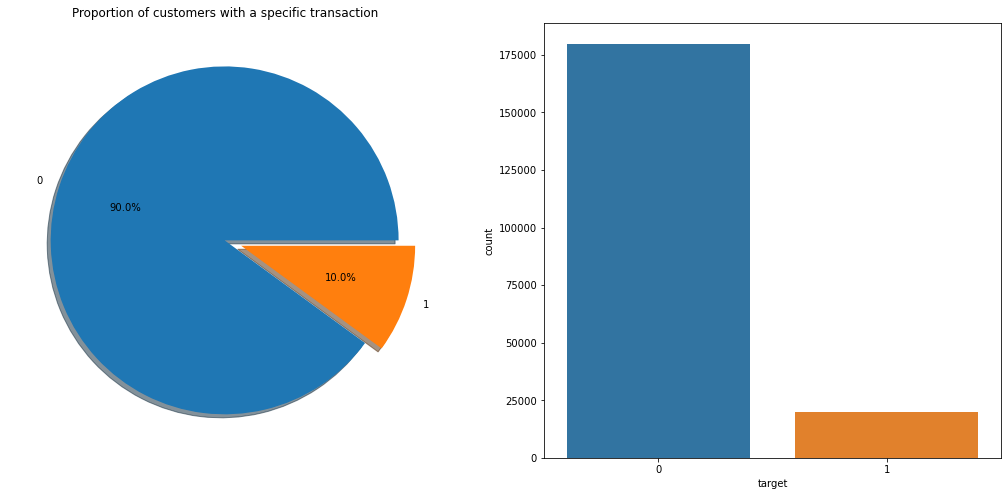

In [4]:
f,ax=plt.subplots(1,2,figsize=(18,8))
InicialData['target'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Proportion of customers with a specific transaction')
ax[0].set_ylabel('')
sns.countplot('target',data=InicialData,ax=ax[1])
ax[1].set_title('')
plt.show()

In [5]:
def summary(data):
    Percent = (data.isnull().sum()/len(data)*100)
    Summary = pd.DataFrame( Percent, columns=[ 'Percent'])
    TypeInfo = []
    Sample = []
    NumberSample = data.shape[0]
    for column_i in data.columns:
        ColumnType = str(data[column_i].dtype)
        ColumnSample = list(data.loc[randint(0,NumberSample,1),column_i])
        TypeInfo.append(ColumnType)
        Sample.append(ColumnSample)
    Summary['Type'] = TypeInfo
    Summary['Sample'] = Sample
    print(pd.crosstab(Summary['Type'],columns=["Crosstab Types"]))
    return(np.transpose(Summary))

In [6]:
summary(InicialData)

col_0    Crosstab Types
Type                   
float64             200
int64                 1
object                1


,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
Percent,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Type,object,int64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
Sample,[train_143228],[0],[8.1962],[1.5818],[7.1923],[5.229],[14.18],[-13.1849],[5.141],[15.113],...,[3.509],[7.4942],[-0.1143],[5.6674],[16.3451],[-1.0808],[-1.271],[7.9853],[12.7622],[12.2981]


In [7]:
summary(TestData)

col_0    Crosstab Types
Type                   
float64             200
object                1


,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
Percent,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Type,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
Sample,[test_73010],[9.9617],[1.399],[7.6495],[5.5117],[12.3647],[-6.0412],[5.2554],[14.6406],[1.0232],...,[4.1382],[1.7831],[0.4293],[7.5964],[23.9126],[-0.4997],[10.4481],[8.9356],[18.2119],[-2.2699]


# Univariate analysis 

In [8]:
InicialData.drop("target",axis=1).describe()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,7.567236,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,1.235070,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,3.970500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,6.618800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,7.629600,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,8.584425,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,11.150600,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


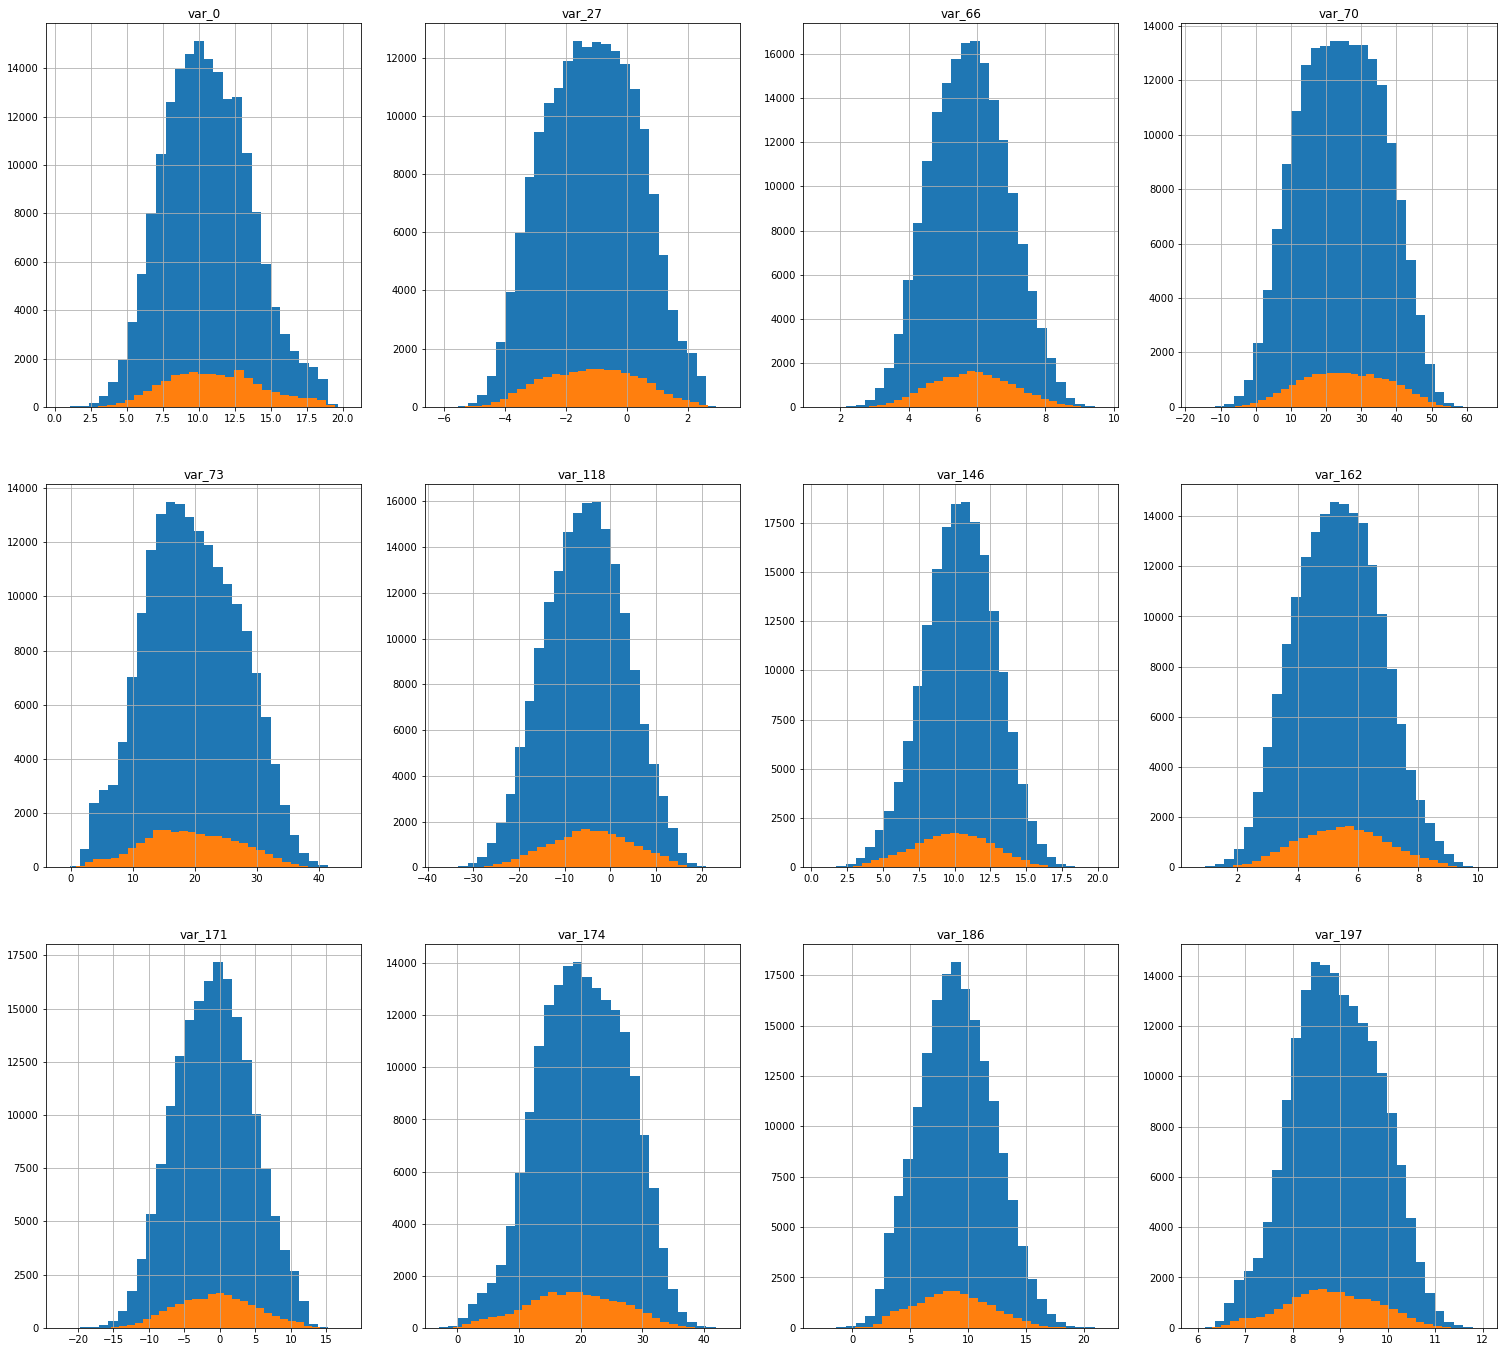

In [9]:
numberRandom = 12
RandomColumn = InicialData.iloc[:,np.sort(randint(2,203,numberRandom))].columns
plt.figure(figsize=(26, 24))
for i,RandomColumn_i in enumerate(RandomColumn):
    plt.subplot(3, 4, i + 1)
    plt.title(RandomColumn_i)
    InicialData.groupby("target")[RandomColumn_i].hist(bins=30,)

> Looking if there are difference in train and test distribution 

In [10]:
def CoefficientVariatonIn(train,test):
    CvTrain = []
    CvTest = []
    Z_test = []
    for column_i in train.columns:
        CvTrain_i = train[column_i].std()/train[column_i].mean()*100
        CvTest_i = test[column_i].std()/test[column_i].mean()*100
        Z_test_i = (train[column_i].mean()-test[column_i].mean())/np.sqrt(train[column_i].var()+test[column_i].var())
        
        CvTrain.append(CvTrain_i)
        CvTest.append(CvTest_i)
        Z_test.append(Z_test_i)
    Summary = pd.DataFrame( train.columns, columns=[ 'ColumnName'])    
    Summary['CvTrain'] = CvTrain
    Summary['CvTest'] = CvTest
    Summary["Z_test"] = Z_test
    Summary = Summary.sort_values("Z_test",ascending=False)
    return(np.transpose(Summary))

In [11]:
Results = CoefficientVariatonIn(InicialData.drop(["ID_code","target"],axis=1),TestData.drop("ID_code",axis=1))
Results

,160,190,46,123,67,100,182,95,177,56,...,199,36,146,147,53,161,189,26,88,90
ColumnName,var_160,var_190,var_46,var_123,var_67,var_100,var_182,var_95,var_177,var_56,...,var_199,var_36,var_146,var_147,var_53,var_161,var_189,var_26,var_88,var_90
CvTrain,44.8499,140.98,25.2551,86.8729,61.6677,-139.105,1246.46,-736.417,22.1233,21.2889,...,-313.78,142.645,24.3578,-224.592,12.7277,3.86876,130.865,-146.042,28.6279,-79.4821
CvTest,45.0431,142.683,25.3184,87.4251,62.0332,-137.573,1375.73,-695.192,22.1379,21.3763,...,-320.317,140.998,24.2672,-229.91,12.7072,3.86734,129.173,-149.254,28.5817,-80.6541
Z_test,0.00735295,0.00693411,0.0066112,0.00602116,0.00591415,0.00566004,0.00533939,0.00505682,0.00495016,0.0049307,...,-0.00544295,-0.00590527,-0.00591036,-0.00595571,-0.00627662,-0.0065148,-0.00695455,-0.00850951,-0.00995688,-0.0114507


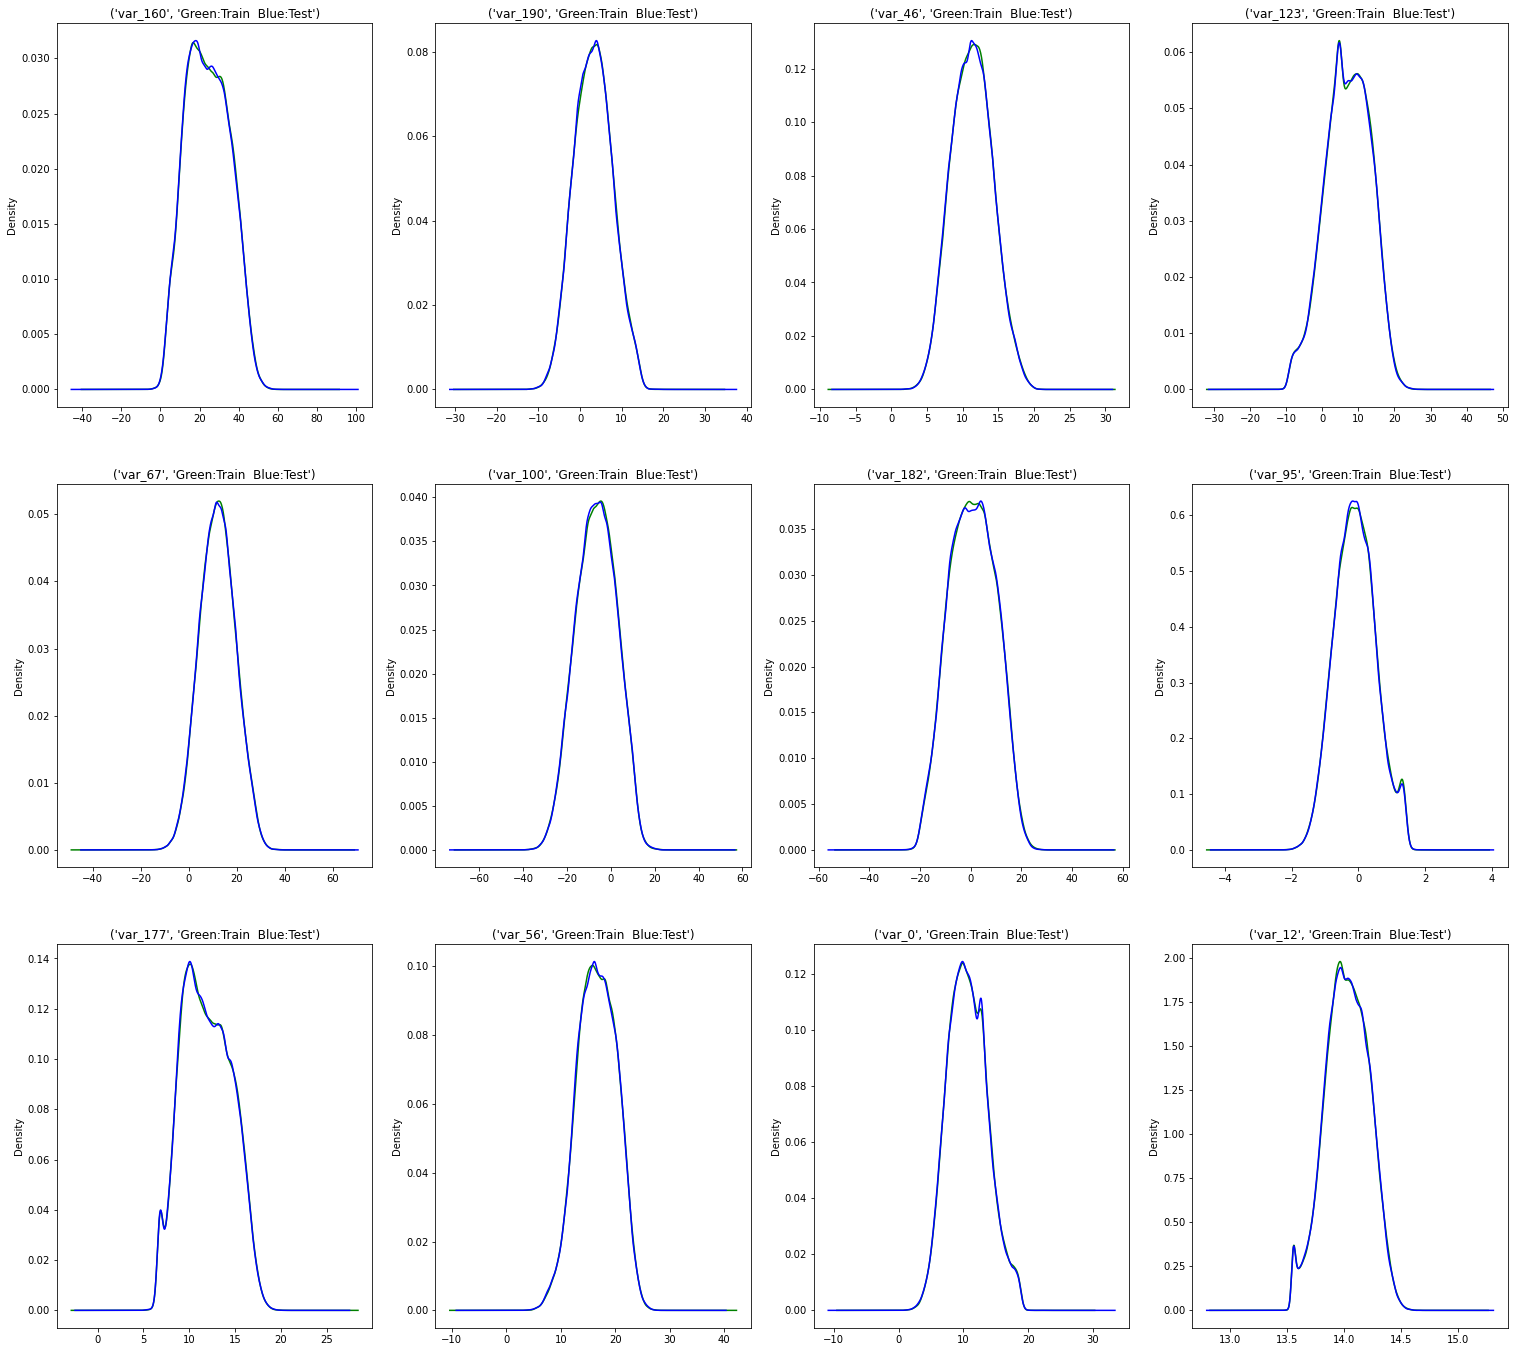

In [12]:
Top12VariablesDifferences = list(Results.iloc[0,:12])
plt.figure(figsize=(26, 24))
for i,Top12VariablesDifferences_i in enumerate(Top12VariablesDifferences):
    plt.subplot(3, 4, i + 1)
    plt.title((Top12VariablesDifferences_i,"Green:Train  Blue:Test"))
    InicialData[Top12VariablesDifferences_i].plot.kde(color = "green" )
    TestData[Top12VariablesDifferences_i].plot.kde(color = "blue" )

In [13]:
pd.crosstab(InicialData.drop("ID_code",axis=1).duplicated(),columns="Is there any duplicates rows?")

col_0,Is there any duplicates rows?
row_0,
False,200000


# Bidimensional analysis

/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


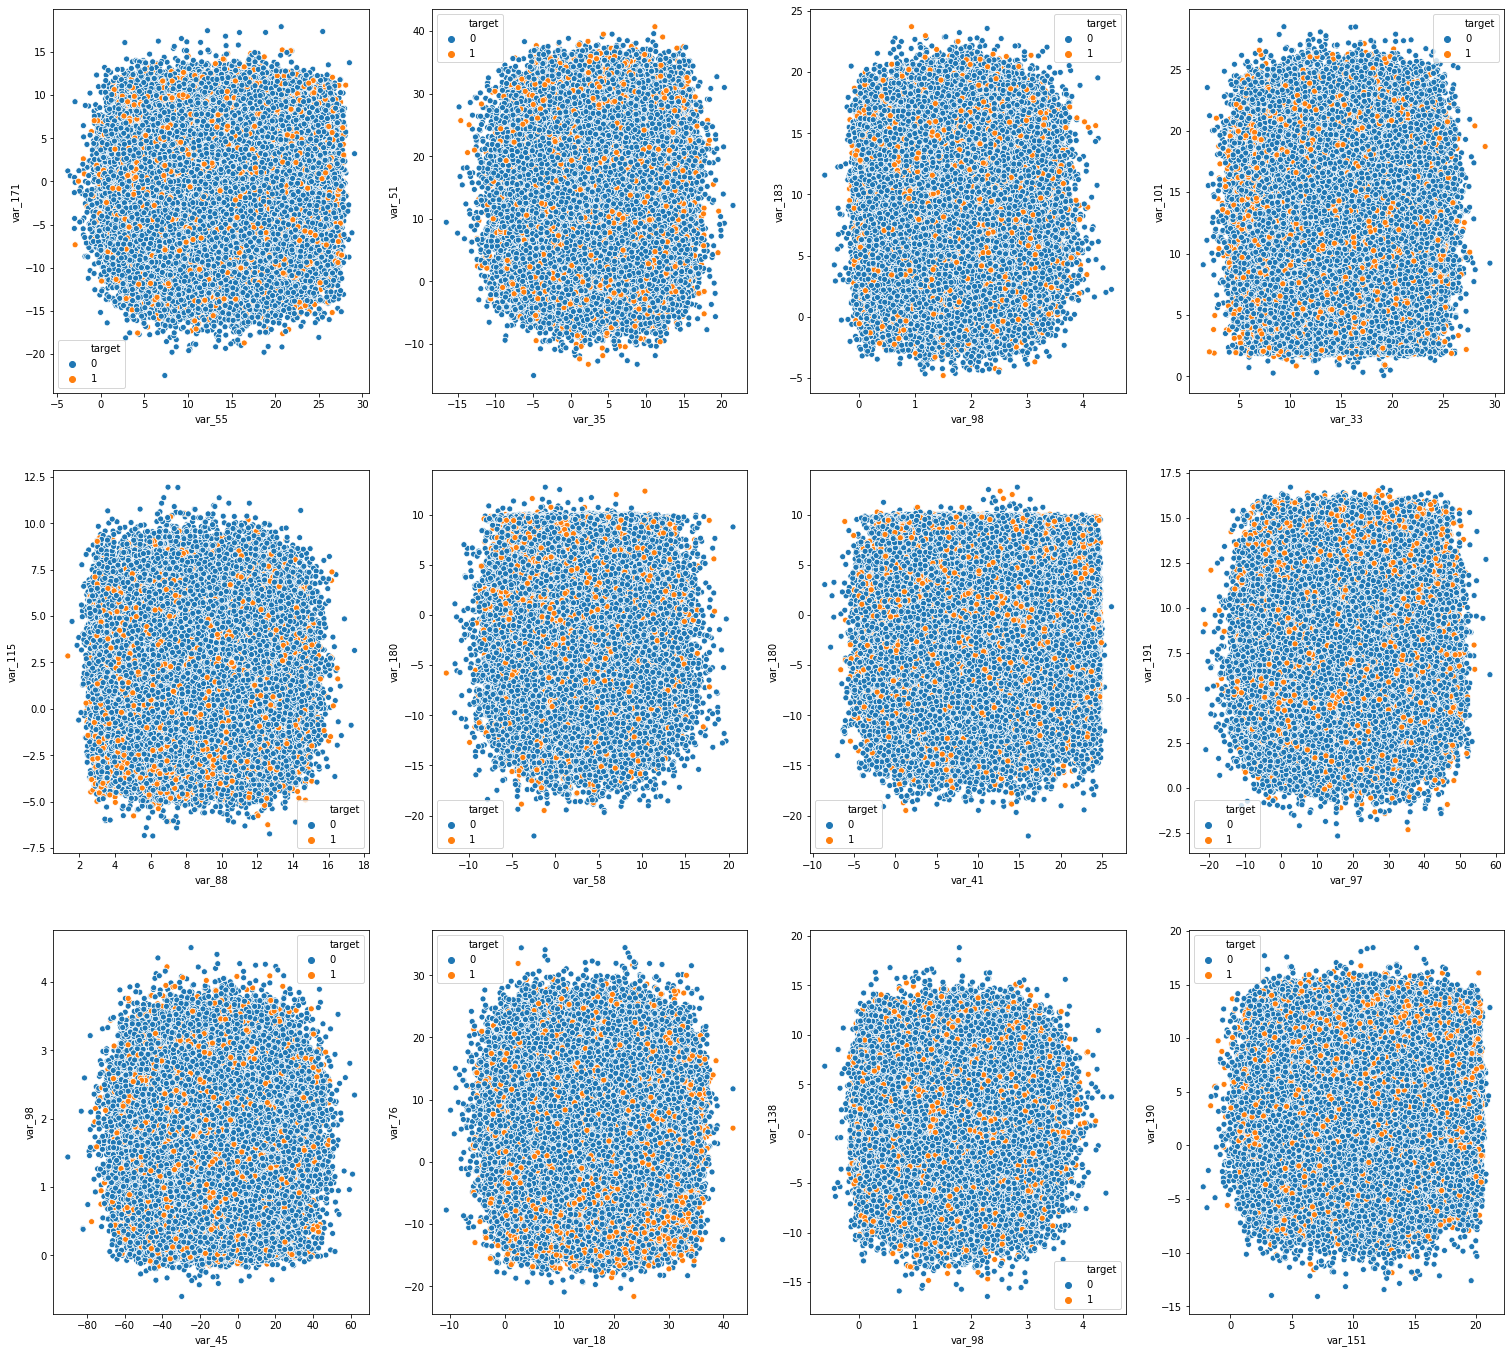

In [14]:
NumberScatterPLots = 12
plt.figure(figsize=(26, 24))
for NumberScatterPLots_i in range(NumberScatterPLots):
    plt.subplot(3, 4, NumberScatterPLots_i + 1)
    RandomColumn = InicialData.iloc[:,np.sort(randint(2,203,2))].columns
    RandomColumn_x = RandomColumn[0]
    RandomColumn_y = RandomColumn[1]
    sns.scatterplot(x=RandomColumn_x, y=RandomColumn_y, hue='target', data=InicialData) 

# Conclusion

* The are a complex relation between features.
* Non separable space between the target.
* 200 features in the Real support.
* The target is imbalanced.


# <a id='1'>Data Preparation</a> 

Because we have a set of complex variables and nonlinear separable data, then some nonparametric models like neural networks, random forest or gradient boosting (algorithm of boosting with decision trees) can be used. 



* Neural networks works with distances, so the features must be scaled to have same weights
* In the context of gradient boosting, the lightGBM framework is used, it is not neccesary to transform the data set

In [15]:
y_train = InicialData[["target","ID_code"]].copy().set_index("ID_code")
train   = InicialData.drop("target",axis=1).set_index("ID_code")
test    = TestData.set_index("ID_code") 

# Data scaling for deep learning framework

In [16]:
FunctionScaler = StandardScaler()                          
X_trainDL = FunctionScaler.fit_transform(train)            
X_testDL = FunctionScaler.transform(test)     

# <a id='1'>Modeling</a> 

 # LightGBM framework with stratified k-fold cross validation
 
I tried modeling with the standardized features and with the originals features. The best results is with the originals ones. AUC(original):  0.8977 AUC(standardized): 0.8965.

In [17]:
kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=123)
test_probsLGBM = []
train_probsLGBM = []
importanceFeatures = []

for i,(a,b) in enumerate(kf.split(train,y_train.loc[train.index, "target"])) :
    Xt = train.iloc[a,:]
    yt = y_train.loc[Xt.index, "target"]
    
    Xv = train.iloc[b,:]
    yv = y_train.loc[Xv.index, "target"]
    print("*+*+*+*+*entrenando fold: {} ".format(i+1))
    
    learner = LGBMClassifier(n_estimators=10,learning_rate=0.04,num_iterations=5000,lambda_l2=4 ,lambda_l1 =4
                                 ,num_leaves =7,max_depth=5,min_data_in_leaf =900,early_stopping_rounds=200,feature_fraction= 0.8
                            ,bagging_fraction=0.85,bagging_freq=10)
    
    learner.fit(Xt, yt  , eval_metric="auc",eval_set= [(Xt, yt),(Xv, yv)], verbose=1000)
    
    
    train_probsLGBM.append(pd.Series(learner.predict_proba(Xv)[:, -1],
                                index=Xv.index, name="probs"+ str(i)))
    test_probsLGBM.append(pd.Series(learner.predict_proba(test)[:, -1],
                                index=test.index, name="fold_" + str(i)  ))
    importanceFeatures.append(pd.Series(learner.feature_importances_ / learner.feature_importances_.sum(), index=Xt.columns))

test_probsLGBM = pd.concat(test_probsLGBM, axis=1).mean(axis=1)
train_probsLGBM = pd.concat(train_probsLGBM, axis=1)
importanceFeatures = pd.concat(importanceFeatures, axis=1).mean(axis=1)

*+*+*+*+*entrenando fold: 1 


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds
[1000]	training's auc: 0.916774	training's binary_logloss: 0.201829	valid_1's auc: 0.893724	valid_1's binary_logloss: 0.218002
[2000]	training's auc: 0.931616	training's binary_logloss: 0.178566	valid_1's auc: 0.901798	valid_1's binary_logloss: 0.20376
[3000]	training's auc: 0.940837	training's binary_logloss: 0.166362	valid_1's auc: 0.903039	valid_1's binary_logloss: 0.200681
Early stopping, best iteration is:
[3193]	training's auc: 0.942472	training's binary_logloss: 0.164329	valid_1's auc: 0.903314	valid_1's binary_logloss: 0.200258
*+*+*+*+*entrenando fold: 2 
Training until validation scores don't improve for 200 rounds
[1000]	training's auc: 0.918271	training's binary_logloss: 0.200993	valid_1's auc: 0.887434	valid_1's binary_logloss: 0.220037
[2000]	training's auc: 0.933485	training's binary_logloss: 0.177301	valid_1's auc: 0.895112	valid_1's binary_logloss: 0.207194
Early stopping, best iteration is:
[2706]	training'

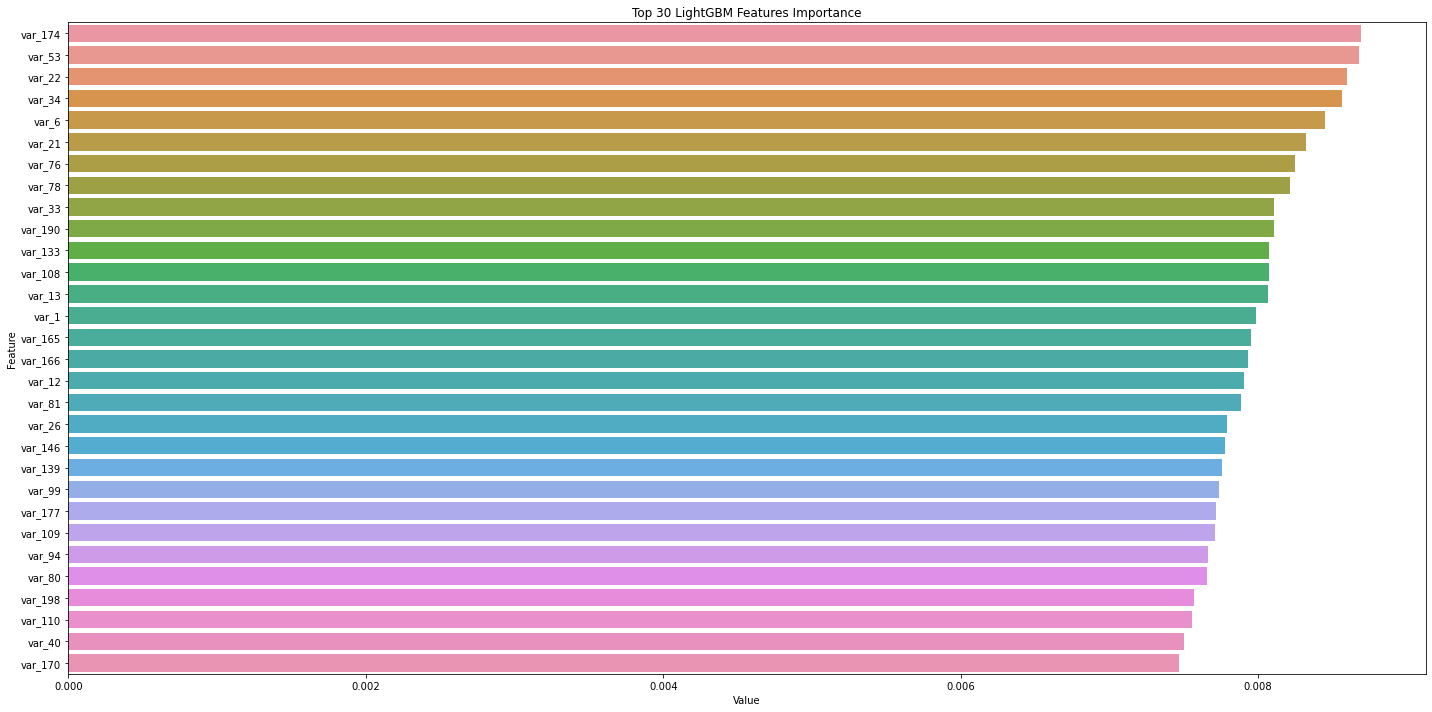

In [18]:
Top30FeaturesLGBM = importanceFeatures.sort_values(ascending = False).head(30).reset_index()
Top30FeaturesLGBM.columns = ["Feature","Value"]
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=Top30FeaturesLGBM)
plt.title('Top 30 LightGBM Features Importance')
plt.tight_layout()
plt.show()

In [19]:
y_true = y_train.values
y_scores = train_probsLGBM.mean(axis=1).to_frame().loc[y_train.index,].values
print(f'LightGBM CV: {metrics.roc_auc_score(y_true, y_scores)}')

LightGBM CV: 0.8977485875346919


# CNN framework with stratified k-fold cross validation

In [20]:
kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=123)
test_probsCNN = []
train_probsCNN = []

for i,(a,b) in enumerate(kf.split(train,y_train.loc[train.index, "target"])) :
    Xt = X_trainDL[a]
    yt = y_train.iloc[a,]
    Xt = Xt.reshape(a.shape[0], 20, 10, 1)
               
    Xv = X_trainDL[b]
    XvOriginal = train.iloc[b,:]
    Xv = Xv.reshape(b.shape[0], 20, 10, 1)
    yv = y_train.iloc[b, ]
    print("*+*+*+*+*entrenando fold: {} ".format(i+1))
    input_len = Xt.shape[1]

    
    model = Sequential()
    model.add(Conv2D(128, kernel_size=3, activation='relu', input_shape = (20,10,1) ))
    model.add(Conv2D(64, kernel_size=3, activation='relu'))
    model.add(Conv2D(32, kernel_size=3, activation='relu'))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
    model.summary()
    callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2)
    model.fit(Xt, yt, batch_size=64, validation_data=(Xv, yv), epochs=10,callbacks=[callback])
        
    train_probsCNN.append(pd.Series(model.predict(Xv)[:, 0],
                                        index=XvOriginal.index, name="probs"+ str(i)))
    test_probsCNN.append(pd.Series(model.predict(X_testDL.reshape(200000,20,10,1))[:, 0],
                                        index=test.index, name="fold_" + str(i)  ))
        

test_probsCNN = pd.concat(test_probsCNN, axis=1).mean(axis=1)
train_probsCNN = pd.concat(train_probsCNN, axis=1)

*+*+*+*+*entrenando fold: 1 
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 18, 8, 128)        1280      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 6, 64)         73792     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 4, 32)         18464     
_________________________________________________________________
flatten (Flatten)            (None, 1792)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1793      
Total params: 95,329
Trainable params: 95,329
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
2500/2500 [==============================] - 129s 51ms/step - loss: 0.2633 - a

In [21]:
y_true = y_train.values
y_scores = train_probsCNN.mean(axis=1).to_frame().loc[y_train.index,].values
print(f'CNN CV: {metrics.roc_auc_score(y_true, y_scores)}')

CNN CV: 0.8755600007130739


# <a id='1'>Evaluation</a> 

Some metrics can be used to evaluate the performance of classification of the models, but bear in mind that the target imbalanced. The AUC, F1-score, can be used in such situation. Now, another topic is to find the best cut-off point to classify if a customers will make a specific transaction in Santander bank. In this context, the cut-off point is estimated for each model maximizing the F1_score. 

# 1.  LightGBM cut-off point and evaluation

In [22]:
from scipy.optimize import differential_evolution
y_true = y_train.values
y_scores = train_probsLGBM.mean(axis=1).to_frame().loc[y_train.index,].values
optimization = differential_evolution(lambda c: -(metrics.f1_score(y_true, list(map(int, y_scores>c[0])) )), [(0, 1)])


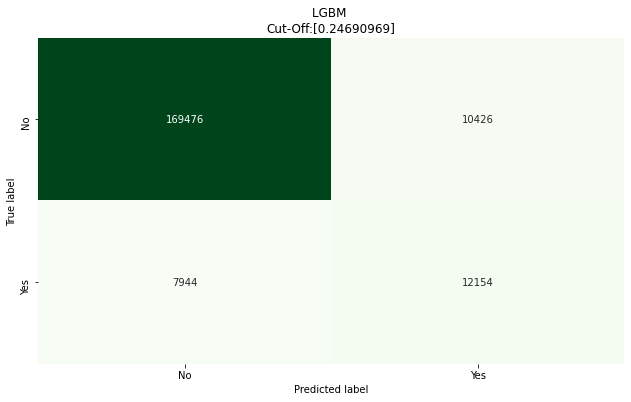

In [23]:
y_pred = list(map(int, y_scores>optimization.x))
ConfusionMatrixLGBM = metrics.confusion_matrix(y_true, y_pred) 

ConfusionMatrixLGBM = pd.DataFrame(ConfusionMatrixLGBM,
                     index = ['No','Yes'], 
                     columns = ['No','Yes'])

plt.figure(figsize=(10.5,6))
sns.heatmap(ConfusionMatrixLGBM, annot=True,cbar=False,cmap="Greens",fmt="d")
plt.title('LGBM \nCut-Off:{}'.format(optimization.x))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [24]:
precision, recall, fscore, support = metrics.precision_recall_fscore_support(y_true, y_pred)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.95522489 0.53826395]
recall: [0.94204623 0.60473679]
fscore: [0.94858979 0.56956746]
support: [179902  20098]


# 2.  CNN cut-off point and evaluation

In [25]:
from scipy.optimize import differential_evolution
y_true = y_train.values
y_scores = train_probsCNN.mean(axis=1).to_frame().loc[y_train.index,].values
optimization = differential_evolution(lambda c: -(metrics.f1_score(y_true, list(map(int, y_scores>c[0])) )), [(0, 1)])

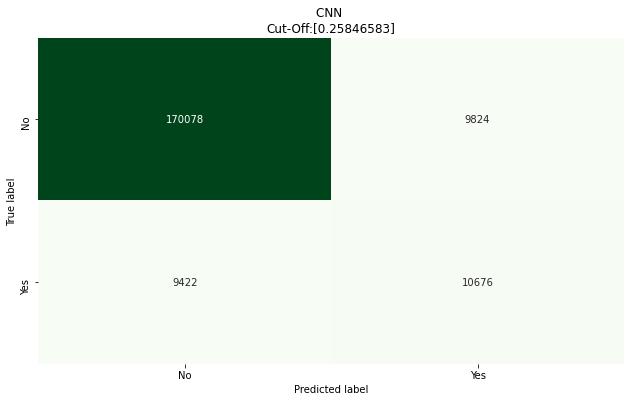

In [26]:
y_pred = list(map(int, y_scores>optimization.x))
ConfusionMatrixCNN = metrics.confusion_matrix(y_true, y_pred) 

ConfusionMatrixCNN = pd.DataFrame(ConfusionMatrixCNN,
                     index = ['No','Yes'], 
                     columns = ['No','Yes'])

plt.figure(figsize=(10.5,6))
sns.heatmap(ConfusionMatrixCNN, annot=True,cbar=False,cmap="Greens",fmt="d")
plt.title('CNN \nCut-Off:{}'.format(optimization.x))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [27]:
precision, recall, fscore, support = metrics.precision_recall_fscore_support(y_true, y_pred)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.94750975 0.52078049]
recall: [0.94539249 0.53119713]
fscore: [0.94644994 0.52593724]
support: [179902  20098]


# <a id='1'>Private Leaderbord score in Santander competition</a> 

In [28]:
test_prob = pd.DataFrame(test_probsLGBM.rename("target"))
test_prob.to_csv("lightgbm_baseline.csv", header=True)

![](https://raw.githubusercontent.com/diego-renato/Santander-Customer-Transaction/master/Images/LightGBM.jpg)

